In [1]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (Compose, LoadImaged, AddChanneld, Lambdad, Transpose, MapTransform, Activations, AsDiscrete, RandGaussianSmoothd, CropForegroundd, SpatialPadd, ScaleIntensityd, ToTensord, RandSpatialCropd, CenterSpatialCropd,
                              Rand3DElasticd, RandAffined, RandRotated, RandZoomd, Spacingd, Orientationd, Resized, ThresholdIntensityd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd, NormalizeIntensityd, RandFlipd, ScaleIntensityRanged, RandCropByPosNegLabeld)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from loss_functions.dice_loss import SoftDiceLoss
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os 
import glob
import pickle
import sys
from my_transform import MyCrop,DownsampleSegForDSTransform,MyToTensord


## Load Data

In [2]:
# Determine the training set and validation set used by the pretrained model
with open(os.path.join("model","3D",'fold_1_batch_train_metric.pickle'), 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    batch_metric = pickle.load(f)

batch_metric['batch_train_loss'] = np.array(batch_metric['batch_train_loss'])

for i,j in enumerate(batch_metric['batch_train_metric']):
    batch_metric['batch_train_metric'][i] = j.cpu().numpy()
batch_metric['batch_train_metric'] = np.array(batch_metric['batch_train_metric'])

batch_filename = batch_metric['batch_filename']
batch_train_loss = batch_metric['batch_train_loss']
batch_train_metric = batch_metric['batch_train_metric']

In [20]:
# set_determinism(seed=0) # Set deterministic training for reproducibility
num_workers = 0 if sys.platform.startswith('win32') else 4

test = False
if test == True:
    train_images = sorted(
        glob.glob(os.path.join("data","NIH Pancreas", "imagesTr", "*.nii.gz")))
    # train_labels = sorted(
    #     glob.glob(os.path.join( "labelsTr_modified", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join("data","NIH Pancreas", "labelsTr", "*.nii.gz")))
else:
    train_images = sorted(
        glob.glob(os.path.join("data", "imagesTr", "*.nii.gz")))
    # train_labels = sorted(
    #     glob.glob(os.path.join( "labelsTr_modified", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join("data", "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = np.array(data_dicts)[tuple([batch_train_metric>=0.85])].tolist(), np.array(data_dicts)[tuple([batch_train_metric<0.85])].tolist()
train_files.__len__(),val_files.__len__()
train_files, val_files = train_files[:2], val_files[7:8]

In [21]:
train_files, val_files,batch_train_loss[batch_train_metric<0.85][7:9]

([{'image': 'data\\imagesTr\\pancreas_001.nii.gz',
   'label': 'data\\labelsTr\\pancreas_001.nii.gz'},
  {'image': 'data\\imagesTr\\pancreas_004.nii.gz',
   'label': 'data\\labelsTr\\pancreas_004.nii.gz'}],
 [{'image': 'data\\imagesTr\\pancreas_086.nii.gz',
   'label': 'data\\labelsTr\\pancreas_086.nii.gz'}],
 array([-0.6741769, -0.7637811], dtype=float32))

# Setup transforms for training and validation

In [22]:
from utilities.downsampling import downsample_seg_for_ds_transform

patch_size, image_spacing = (224, 224, 40), (0.8, 0.8, 2.5)
net_num_pool_op_kernel_sizes = [[1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [1, 2, 2]]
deep_supervision_scales = [[1, 1, 1]] + list(list(i) for i in 1 / np.cumprod(
            np.vstack(net_num_pool_op_kernel_sizes), axis=0))[:-1]

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=["image", "label"], pixdim=image_spacing,
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # crop CropForeground
        CropForegroundd(keys=['image', 'label'], source_key='image'),

        # 灰度值阶段在[-96,215]之间
        ThresholdIntensityd(keys=['image'], threshold=-96, above=True, cval=-96),  # Threshold CT
        ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),

        NormalizeIntensityd(keys=['image']),                                          # augmentation
        ScaleIntensityd(keys=['image']),                                              # intensity
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-96, a_max=215,
        #     b_min=0.0, b_max=1.0, clip=True),


        # RandRotated(keys=['image', 'label'], 
        #     prob=1,
        #     range_x =np.pi / 6, 
        #     range_y =np.pi / 6,
        #     range_z =np.pi / 6,
        #     padding_mode="border"),

        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),

        # pad if the image is smaller than patch
        SpatialPadd(keys=['image', 'label'],
            spatial_size=patch_size, method='end'),


        Lambdad(keys=["image", "label"],
                func=lambda x:x.transpose(0, 3, 2, 1)),
        Lambdad(keys=["label"],
                func=lambda x:downsample_seg_for_ds_transform(x,ds_scales=deep_supervision_scales)),
        # ToTensord(keys=['image', 'label']) # already tensor
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=["image", "label"], pixdim=image_spacing,
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),


        # 灰度值阶段在[-96,215]之间
        ThresholdIntensityd(keys=['image'], threshold=-96, above=True, cval=-96),  # Threshold CT
        ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),

        NormalizeIntensityd(keys=['image']),                                          # augmentation
        ScaleIntensityd(keys=['image']),                                              # intensity
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-96, a_max=215,
        #     b_min=0.0, b_max=1.0, clip=True),

        # crop CropForeground
        # CropForegroundd(keys=['image', 'label'], source_key='image'),

        # Find where the tumor is located and crop the image
        MyCrop(
            keys=["image", "label"],
            source_key="label",
            select_fn=lambda x: x > 0, 
            margin=0,
            spatial_size=patch_size,
            # spatial_size=(512,512,40),

        ),
        
        CenterSpatialCropd(keys=["image", "label"],roi_size = patch_size),
        # SpatialPadd(keys=['image', 'label'], spatial_size=patch_size, method= 'end'),  # pad if the image is smaller than patch

        # SpatialPadd(keys=['image', 'label'],
        # spatial_size=patch_size, method='end'),

        Lambdad(keys=["image", "label"],
                func=lambda x:x.transpose(0, 3, 2, 1)),
        
        Lambdad(keys=["label"],
                func=lambda x:downsample_seg_for_ds_transform(x,ds_scales=deep_supervision_scales)),
        # DownsampleSegForDSTransform(keys=["label"],deep_supervision_scales=deep_supervision_scales),

    ]
)


In [23]:
# test = Compose([LoadImaged(keys=['image', 'label'],image_only=True),
#                 AddChanneld(keys=['image', 'label']),
#                 # Spacingd(keys=["image", "label"], pixdim=image_spacing, mode=("bilinear", "nearest")),
#                 # ToTensord(keys=['image', 'label'])
# ])(val_files)

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [24]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1, num_workers=6)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0,
                          pin_memory=torch.cuda.is_available())


Loading dataset: 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


In [25]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, 
    cache_rate=1, num_workers=6)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                        pin_memory=torch.cuda.is_available())


Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


## Create Model, Loss, Optimizer

In [26]:
from network_trainer import NetworkTrainer

## Execute a typical PyTorch training process

In [27]:
continue_train = True
using_pretrained = True
modify=True
num_classes=3

if(continue_train != True):
    final_epoch = -1
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_train_loss_all = []
    epoch_val_loss_all = []
    metric_all = []
    lr = []
    if using_pretrained:
        preload = os.path.join('model', '3D', 'model_final_checkpoint.model')
    else:
        preload = os.path.join('results', 'best_metric_model_128.pth')

else:
    with open(os.path.join('settings', 'data_199.pickle'), 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data_0 = pickle.load(f)

    final_epoch = data_0['final_epoch']
    val_interval = data_0['val_interval']
    best_metric = data_0['best_metric']
    best_metric_epoch = data_0['best_metric_epoch']
    epoch_train_loss_all = data_0['epoch_train_loss_all']
    epoch_val_loss_all = data_0['epoch_val_loss_all']
    metric_all = data_0['metric_all']
    lr = data_0['lr']
    if using_pretrained:
        preload = os.path.join('model', '3D', 'model_final_checkpoint.model')
    else:
        preload = os.path.join('results', 'best_metric_model_128.pth')


In [28]:
import collections
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(preload)['state_dict']

for k, v in state_dict.items():
    name = k 
    # skip
    # if k[:11] == "seg_outputs" and k[12]!='4':
    #     new_state_dict[name] = torch.zeros([j if i!=1 else j+32 for i,j in enumerate(v.shape)])
    #     new_state_dict[name][:,:v.shape[1],:,:,:] = v
    # else:
    #     new_state_dict[name] = v

    if k[:11] == "seg_outputs":
        new_state_dict[name] = torch.zeros([j if i!=0 else num_classes for i,j in enumerate(v.shape)])
        # print(name,new_state_dict[name].shape)
        if num_classes==3:
            new_state_dict[name][0] = v[0,:,:,:,:]
            new_state_dict[name][1] = v[1,:,:,:,:]
            new_state_dict[name][2] = v[2,:,:,:,:]
        else:
            new_state_dict[name][0] = v[0,:,:,:,:]
            new_state_dict[name][1] = v[2,:,:,:,:] + v[1,:,:,:,:]
    else:
        new_state_dict[name] = v




In [29]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
else:
    print("WARNING!!! You are attempting to run training on a CPU (torch.cuda.is_available() is False). This can be VERY slow!")

Unet = NetworkTrainer(num_classes=num_classes, using_UNET_3D=True, epoch=final_epoch+1,deep_supervision=True)
Unet.initialize()
Unet.device = 'cpu'
Unet.network.to(Unet.device);
Unet.update_lr(epoch=final_epoch+1)

if preload is not None:
    # model.load_state_dict(torch.load(preload))
    checkpoint = torch.load(preload)
    if using_pretrained:
        if modify==True:
            Unet.load_state_dict(new_state_dict)
        else:
            Unet.load_state_dict(checkpoint['state_dict'])
    else:
        Unet.load_state_dict(checkpoint)


learning rate = 0.0007440
model has been loaded


In [30]:
# 计算模型大小
size = 0
for key,value in new_state_dict.items():
    if type(value) == collections.OrderedDict:
        for key,value in new_state_dict.items():
            size += value.nelement() * value.element_size()
    else:
        size += value.nelement() * value.element_size()
size

123035136

# Model test

In [98]:

test_val_data,test_train_data = first(val_loader),first(train_loader)

val_image,train_image = test_val_data["image"],test_train_data["image"]
val_label,train_label = test_val_data["label"],test_train_data["label"]
# test_val_data = first(val_loader)
# val_image = test_val_data["image"]
# val_label = test_val_data["label"]
train_image.shape,train_label[0].shape
# val_image.shape,val_label[0].shape

(torch.Size([2, 1, 40, 224, 224]), torch.Size([2, 1, 40, 224, 224]))

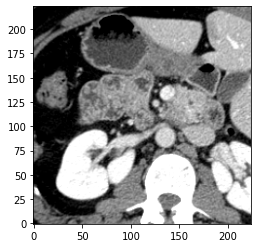

In [139]:
plt.imshow(val_image[0,0,15,:,:].detach().numpy(), cmap="gray",origin='lower')

In [15]:
feature_map_0 = Unet.network.conv_blocks_context[0](val_image)
feature_map_1 = Unet.network.conv_blocks_context[1](feature_map_0)
feature_map_2 = Unet.network.conv_blocks_context[2](feature_map_1)
feature_map_3 = Unet.network.conv_blocks_context[3](feature_map_2)
feature_map_4 = Unet.network.conv_blocks_context[4](feature_map_3)
feature_map_5 = Unet.network.conv_blocks_context[5](feature_map_4)

In [16]:
# texture_feature = downsample_seg_for_ds_transform(feature_map_0.detach().numpy(),ds_scales=deep_supervision_scales)

In [17]:
# plt.imshow(texture_feature[3][0,0,5,:,:], cmap="gray",origin='lower')


In [18]:
transpose_feature_map_5 = Unet.network.tu[0](feature_map_5)
feature_map_4_up = Unet.network.conv_blocks_localization[0](torch.cat((transpose_feature_map_5, feature_map_4), dim=1))

In [19]:
transpose_feature_map_4 = Unet.network.tu[1](feature_map_4_up)
feature_map_3_up = Unet.network.conv_blocks_localization[1](torch.cat((transpose_feature_map_4, feature_map_3), dim=1))

In [20]:
transpose_feature_map_3 = Unet.network.tu[2](feature_map_3_up)
feature_map_2_up = Unet.network.conv_blocks_localization[2](torch.cat((transpose_feature_map_3, feature_map_2), dim=1))

In [21]:
transpose_feature_map_2 = Unet.network.tu[3](feature_map_2_up)
feature_map_1_up = Unet.network.conv_blocks_localization[3](torch.cat((transpose_feature_map_2, feature_map_1), dim=1))

In [22]:
transpose_feature_map_1 = Unet.network.tu[4](feature_map_1_up)
feature_map_0_up = Unet.network.conv_blocks_localization[4](torch.cat((transpose_feature_map_1, feature_map_0), dim=1))

In [29]:
pool_op_kernel_sizes = [[1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [1, 2, 2]]
texture_feature_0 = feature_map_0
texture_feature_1 = Unet.network.pool_outputs(pool_op_kernel_sizes[0])(texture_feature_0)
texture_feature_2 = Unet.network.pool_outputs(pool_op_kernel_sizes[1])(texture_feature_1)
texture_feature_3 = Unet.network.pool_outputs(pool_op_kernel_sizes[2])(texture_feature_2)
texture_feature_4 = Unet.network.pool_outputs(pool_op_kernel_sizes[3])(texture_feature_3)

In [22]:
# Unet.network.seg_outputs

torch.Size([1, 32, 40, 224, 224])


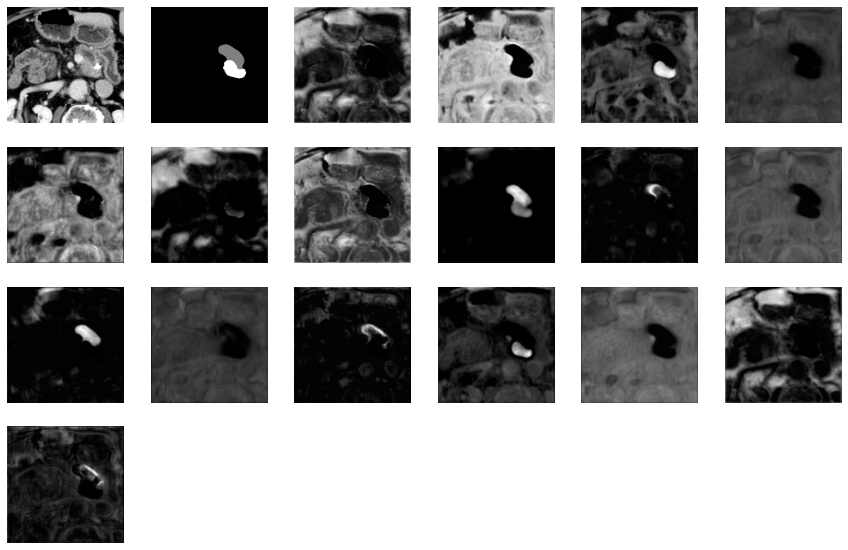

In [23]:
slice = 20
scale = 1
feature_map = feature_map_0_up
print(feature_map.shape)
row = 6
column = 6
plt.figure("check", (15, 15))

plt.subplot(row, column, 1)
plt.axis('off') 
# plt.imshow(val_label[0,0,slice*4,:,:].detach().numpy(), cmap="gray",origin='lower')
plt.imshow(val_image[0,0,slice*scale,:,:].detach().numpy(), cmap="gray",origin='lower')

plt.subplot(row, column, 2)
plt.axis('off') 
plt.imshow(val_label[0][0,0,slice*scale,:,:].detach().numpy(), cmap="gray",origin='lower')

# for i,feature in enumerate(range(0,feature_map.shape[1],2)):
for i,feature in enumerate(range(0,17)):

    plt.subplot(row, column, i+3)
    plt.axis('off') 
    plt.imshow(feature_map[0,feature,slice,:,:].detach().numpy(), cmap="gray",origin='lower')

    # plt.show()

# plt.savefig('feature_map_-1.svg')

In [23]:
# for slice in range(0,40,10):
#     plt.figure("check", (12, 6))
#     plt.subplot(1, 2, 1)
#     # plt.title("image")
#     plt.imshow(val_image[0,0,slice,:,:].numpy(), cmap="gray",origin='lower')
#     plt.subplot(1, 2, 2)
#     plt.imshow(val_label[0][0,0,slice,:,:].numpy(), cmap="gray",origin='lower')

#     plt.show()
#     # plt.savefig('picture/test.svg')

In [81]:
transform = Unet.network.conv_blocks_context[0].named_parameters()
first_transform= transform.__next__()[1]
first_transform.shape

torch.Size([32, 1, 1, 3, 3])

image shape: (32, 1)


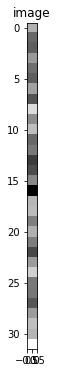

In [86]:
plot(first_transform[:,:,0,0,0].detach().cpu().numpy())

In [9]:
# for i in range(list(Unet.network.parameters()).__len__()):
#     print(list(Unet.network.named_parameters())[i][0],list(Unet.network.parameters())[i].shape)

# TEST3D

In [31]:
# from plot import plot,test_plot_2

test_train_data = first(train_loader)
train_image = test_train_data["image"]
train_label = test_train_data["label"]

# 注意label是list。
test_val_data = first(val_loader)
val_image = test_val_data["image"]
val_label = test_val_data["label"]



In [35]:
test_val_data['image_meta_dict']['filename_or_obj']

['data\\imagesTr\\pancreas_086.nii.gz']

In [33]:
with torch.no_grad():
    predict = Unet.network(val_image[None,0].to('cpu'))

In [37]:
from loss_functions.dice_loss import DC_and_CE_loss,MultipleOutputLoss2
from torch import nn
loss = DC_and_CE_loss(
                {'batch_dice': True, 'smooth': 1e-5, 'do_bg': False}, {})
calculate_dice = SoftDiceLoss(apply_nonlin=lambda x: nn.functional.softmax(
    x, 1), batch_dice=True, do_bg=False, smooth=1e-5)

Unet.loss_function(predict,val_label)


tensor(-0.6742)

In [85]:
val_label[0].shape

torch.Size([1, 1, 40, 224, 224])

In [83]:
from copy import deepcopy
for i in range(5):
    val_label_modify = deepcopy(val_label[i])

    # compare dim 0,1
    val_label_modify[val_label_modify==2] = 0
    print(loss(predict[i][:,0:2,:,:,:],val_label_modify))
    # print(-calculate_dice(predict[i][:,0:2,:,:,:],val_label_modify))

    # # compare dim 02
    # val_label_modify[val_label_modify==1] = 0
    # val_label_modify[val_label_modify==2] = 1
    # # print(loss(predict[i][:,0:3:2,:,:,:],val_label_modify))
    # print(-calculate_dice(predict[i][:,0:3:2,:,:,:],val_label_modify))
    
    del val_label_modify

    

tensor(-0.8690)
tensor(-0.8648)
tensor(-0.8378)
tensor(-0.7611)
tensor(0.6625)


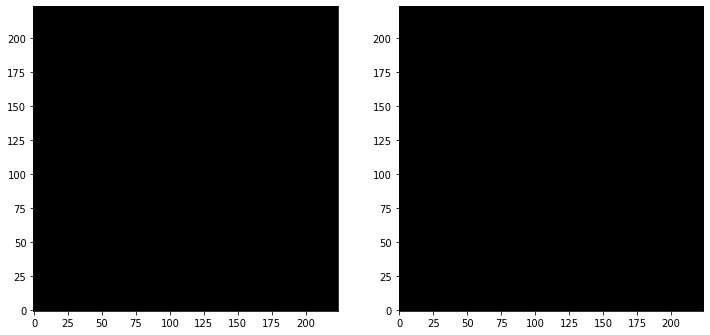

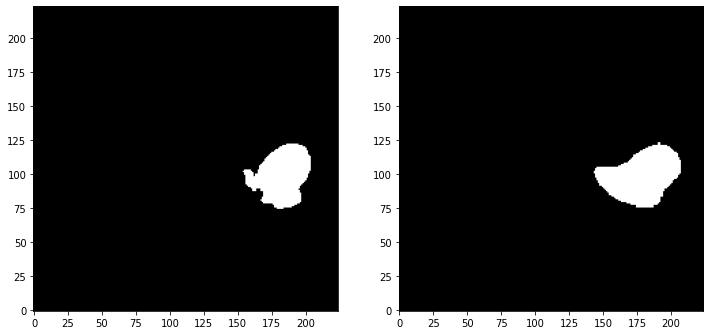

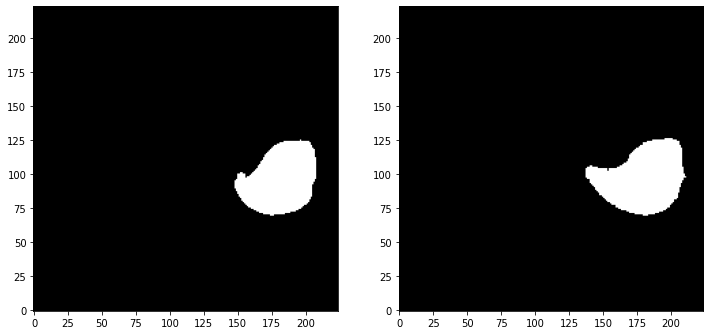

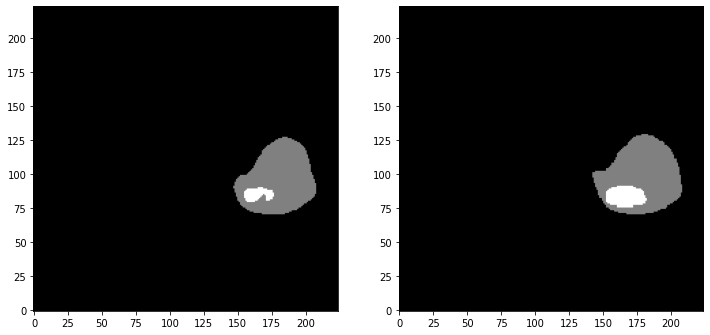

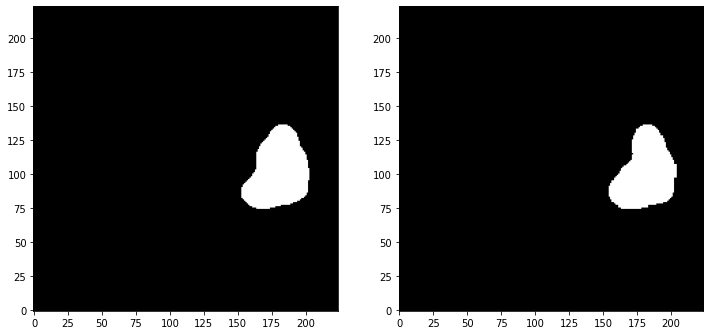

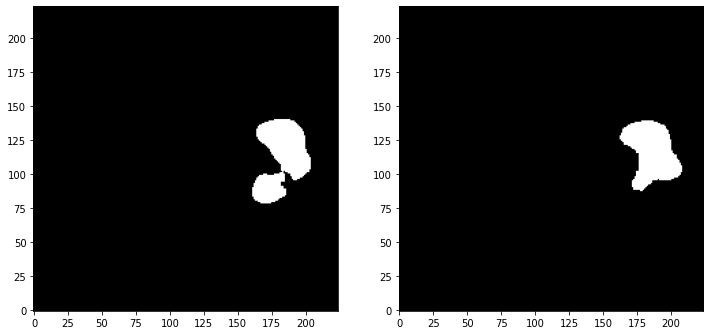

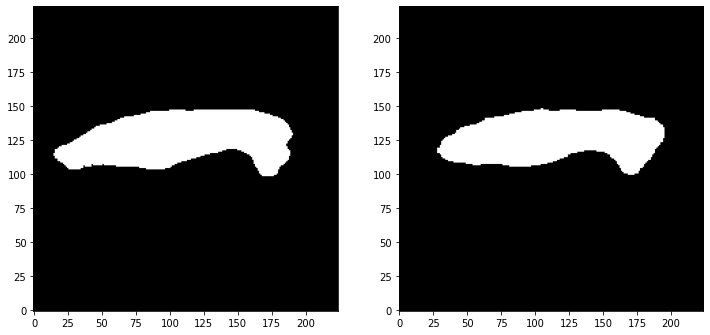

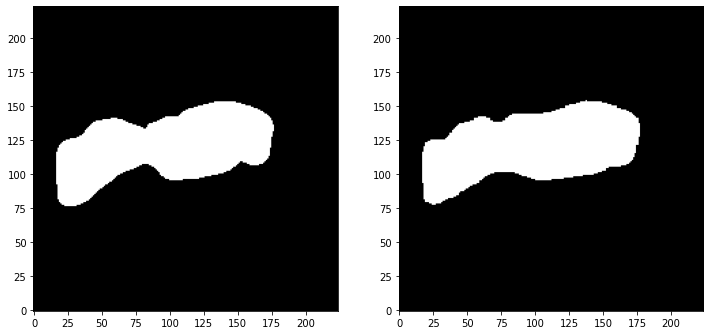

In [34]:
# for slice in range(0,40,10):
#     test_plot_2(AsDiscrete(argmax=True, to_onehot=False, n_classes=3)(predict[0])[0][0], val_label[0][0][None], slice=slice)
show_image=AsDiscrete(argmax=True, to_onehot=False, n_classes=3)(predict[0])
show_label=val_label[0]
for slice in range(0,40,5):
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    # plt.title("image")
    plt.imshow(show_image[0,0,slice,:,:].numpy(), cmap="gray",origin='lower')
    plt.subplot(1, 2, 2)
    plt.imshow(show_label[0,0,slice,:,:].numpy(), cmap="gray",origin='lower')

    plt.show()

# Train

In [ ]:
device = Unet.device
calculate_dice = SoftDiceLoss(apply_nonlin=lambda x: nn.functional.softmax(
    x, 1), batch_dice=True, do_bg=False, smooth=1e-5)

while(Unet.epoch < Unet.max_epochs):
    print("-" * 10)
    print(f"epoch {Unet.epoch + 1}/{Unet.max_epochs}")

# one epoch
    # 1、train
    Unet.network.train()
    epoch_train_loss = []
    step = 0

    for batch_data in train_loader:
        step += 1

        train_inputs = batch_data["image"].to(device)
        for label in batch_data["label"]:
            train_labels.append(label.to(device))
        
        Unet.optimizer.zero_grad()
        train_outputs = Unet.network(train_inputs)
        del train_inputs
        train_loss = Unet.loss_function(train_outputs, train_labels)
        train_loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 12)
        Unet.optimizer.step()
        del train_labels
        train_loss = train_loss.detach().cpu().numpy()
        epoch_train_loss.append(train_loss)
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {train_loss:.4f}")

    epoch_train_loss = np.mean(epoch_train_loss)
    epoch_train_loss_all.append(epoch_train_loss)
    print(f"epoch {Unet.epoch + 1} train loss: {epoch_train_loss:.4f}")

    # 2、validation
    if (Unet.epoch + 1) % val_interval == 0:
        epoch_val_loss = []
        epoch_metric = []

        with torch.no_grad():
            Unet.network.eval()
            for val_data in val_loader:
                val_labels = []
                val_inputs = val_data["image"].to(device)
                for label in val_data["label"]:
                    val_labels.append(label.to(device))
                    
                val_outputs = Unet.network(val_inputs)
                del val_inputs
                val_loss = Unet.loss_function(
                    val_outputs, val_labels).detach().cpu().numpy()
                epoch_val_loss.append(val_loss)

                epoch_metric.append(calculate_dice(
                    val_outputs, val_labels).detach().cpu().numpy())
                del val_labels

            epoch_val_loss = np.mean(epoch_val_loss)
            epoch_val_loss_all.append(epoch_val_loss)
            print(
                f"epoch {Unet.epoch + 1} validation loss: {epoch_val_loss:.4f}")

            epoch_metric = - np.mean(epoch_metric)
            metric_all.append(epoch_metric)
            if epoch_metric > best_metric:
                best_metric = epoch_metric
                best_metric_epoch = Unet.epoch + 1
                torch.save(Unet.network.state_dict(), os.path.join(
                    'results', "best_metric_model_" + str(best_metric_epoch) + ".pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {Unet.epoch + 1} current mean dice: {epoch_metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

    # 3、save model and params
    if (Unet.epoch + 1) % 10 == 0:
        torch.save(Unet.network.state_dict(), os.path.join(
            'results', "metric_model_" + str(Unet.epoch + 1) + ".pth"))
        print("saved metric model")

        # An arbitrary collection of objects supported by pickle.
        lr.append(Unet.optimizer.param_groups[0]['lr'])

        data = {
            'patch_size': patch_size,
            'image_spacing': image_spacing,
            'val_interval': val_interval,
            'final_epoch': Unet.epoch,
            'epoch_train_loss_all': epoch_train_loss_all,
            'epoch_val_loss_all': epoch_val_loss_all,
            'metric_all': metric_all,
            'best_metric': best_metric,
            'best_metric_epoch': best_metric_epoch,
            'lr': lr
        }

        with open('data_' + str(Unet.epoch) + '.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

    # 4、for next epoch
    if Unet.epoch == 100:
        if epoch_val_loss_all[-1] == 0:
            Unet.optimizer.param_groups[0]["momentum"] = 0.95
            Unet.network.apply(InitWeights_He(1e-2))
            print("At epoch 100, the mean foreground Dice was 0. This can be caused by a too "
                  "high momentum. High momentum (0.99) is good for datasets where it works, but "
                  "sometimes causes issues such as this one. Momentum has now been reduced to "
                  "0.95 and network weights have been reinitialized")
    Unet.update_lr()
    Unet.epoch += 1


----------
epoch 1/600
1/1, train_loss: 0.5257
epoch 1 average loss: 0.5257
learning rate = 0.0099850
----------
epoch 2/600


In [18]:
print(
    f"train completed, best_metric: {data['best_metric']:.4f} "
    f"at epoch: {data['best_metric_epoch']}")

train completed, best_metric: 0.0228 at epoch: 160


## Plot the loss and metric

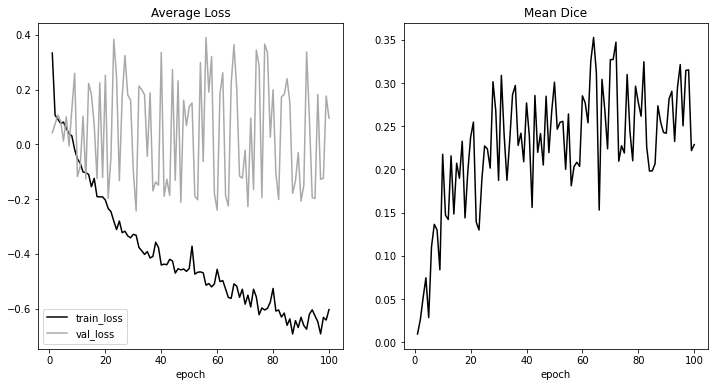

In [147]:
import matplotlib.pyplot as plt
epoch_train_loss_all = data_0['epoch_train_loss_all']
epoch_val_loss_all = data_0['epoch_val_loss_all']
metric_all = data_0['metric_all']
epoch = 100

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average Loss")
# x = [i + 1 for i in range(len(epoch_train_loss_all),350)]
x = [i + 1 for i in range(epoch)]
y1 = epoch_train_loss_all[:epoch]
y2 = epoch_val_loss_all[:epoch]
plt.xlabel("epoch")
plt.plot(x, y1,'black',label='train_loss')
plt.plot(x, y2, 'darkgray',label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Mean Dice")
# x = [1 * (i + 1) for i in range(len(metric_all),350)]
x = [i + 1 for i in range(epoch)]
y = metric_all[:epoch]
plt.xlabel("epoch")
plt.plot(x, y,'black',label='metrics')
# plt.show()
plt.savefig('lossAndMetrics.svg')

# Predict

In [ ]:
Unet.network.training = False
Unet.network.do_ds = False
predict = Unet.network.predict_3D(
    image[0],
    do_mirroring=False, mirror_axes=(0, 1, 2),
    use_sliding_window=True, step_size=0.5,
    patch_size=(40, 224, 224), regions_class_order=(0, 1, 2),
    use_gaussian=True, pad_border_mode='constant',
    pad_kwargs={'constant_values': 0}, all_in_gpu=False, verbose=True,
    mixed_precision=True)
